In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
import os
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Merge historical data

data can be found on [ICPSR website](https://www.icpsr.umich.edu/web/ICPSR/series/64/studies)

In [156]:
%%time

dfs = []
files = glob.glob('../../data/*.tsv')
fields = ['NEWRACE', 'AGE', 'IRSEX', 'HERAGE', 'LSDAGE', 'PCPAGE',
          'CRKAGE', 'ECSAGE', 'COCAGE', 'METHAGE', 'CIGAGE', 'SNUFTRY',
          'CHEWTRY', 'MTHAAGE', 'OXYCAGE', 'CIGTRY ', 'SEDAGE', 'STIMAGE',
          'TRANAGE', 'CIGARTRY', 'INHAGE', 'MJAGE', 'ANALAGE', 'BLNTAGE', 'ALCTRY'] #+ \
    #['MRJMDAYS',  'MRJYDAYS', 'DEPNDALC', 'DEPNDMRJ', 'NDSSDNSP']

for file in files:
    df_n1 = pd.read_csv(file, sep='\t', skipinitialspace=True, nrows=1)
    current_columns = []
    for field in fields:
        if field in df_n1.columns:
            current_columns.append(field)
        elif f'{field}2' in df_n1.columns:
            current_columns.append(f'{field}2')
        else:
            print(f'field {field} not in {file}')
    df = pd.read_csv(file, sep='\t', skipinitialspace=True, usecols=current_columns)
    df['file_name'] = os.path.basename(file)
    dfs.append(df)

field CIGTRY  not in ../../data/32722-0001-Data.tsv
field CIGTRY  not in ../../data/23782-0001-Data.tsv
field MTHAAGE not in ../../data/04596-0001-Data.tsv
field CIGTRY  not in ../../data/04596-0001-Data.tsv
field CIGTRY  not in ../../data/26701-0001-Data.tsv
field CIGTRY  not in ../../data/29621-0001-Data.tsv
field CIGTRY  not in ../../data/36361-0001-Data.tsv
field CIGTRY  not in ../../data/35509-0001-Data.tsv
field MTHAAGE not in ../../data/04373-0001-Data.tsv
field CIGTRY  not in ../../data/04373-0001-Data.tsv
field BLNTAGE not in ../../data/04373-0001-Data.tsv
field MTHAAGE not in ../../data/21240-0001-Data.tsv
field CIGTRY  not in ../../data/21240-0001-Data.tsv
field CIGTRY  not in ../../data/34481-0001-Data.tsv
field CIGTRY  not in ../../data/34933-0001-Data.tsv
CPU times: user 18 s, sys: 598 ms, total: 18.6 s
Wall time: 18.6 s


In [157]:
main_df = pd.concat(dfs)
main_df_backlog = main_df.copy()
main_df.shape  # data diff 613774 (real) - 615701 (paper) = -1927 difference

(613974, 25)

In [158]:
main_df.head(2)

,CIGAGE,SNUFTRY,CHEWTRY,CIGARTRY,ALCTRY,MJAGE,COCAGE,CRKAGE,HERAGE,LSDAGE,PCPAGE,ECSAGE,INHAGE,ANALAGE,OXYCAGE,TRANAGE,STIMAGE,METHAGE,SEDAGE,MTHAAGE,BLNTAGE,AGE2,IRSEX,NEWRACE2,file_name
0,999,991,991,991,16,16,991,991,991,991,991,991,991,991,991,991,991,991,991,991.0,991.0,9,1,2,32722-0001-Data.tsv
1,15,991,991,991,13,14,991,991,991,991,991,991,991,991,991,991,991,991,991,991.0,17.0,12,2,1,32722-0001-Data.tsv


# Preprocessing

In [174]:
file_to_year_mapping = {f:2004+i for i, f in enumerate(sorted([os.path.basename(f) for f in files]))}
class_mapping = {
    'MJAGE': 'MARIJUANA',
    'ALCTRY': 'ALCOHOL',
    'CIGAGE': 'CIGARETTES',
    'NOUSAGE': 'NO_DRUG_USE',
    'CIGARTRY': 'OTHER_TABACCO',
    'SNUFTRY': 'OTHER_TABACCO',
    'CHEWTRY': 'OTHER_TABACCO',
    'HERAGE': 'OTHER_DRUGS',
    'LSDAGE': 'OTHER_DRUGS',
    'PCPAGE': 'OTHER_DRUGS',
    'CRKAGE': 'OTHER_DRUGS',
    'ECSAGE': 'OTHER_DRUGS',
    'COCAGE': 'OTHER_DRUGS',
    'METHAGE': 'OTHER_DRUGS',
    'MTHAAGE': 'OTHER_DRUGS',
    'OXYCAGE': 'OTHER_DRUGS',
    'SEDAGE': 'OTHER_DRUGS',
    'STIMAGE': 'OTHER_DRUGS',
    'TRANAGE': 'OTHER_DRUGS',
    'INHAGE': 'OTHER_DRUGS',
    'ANALAGE': 'OTHER_DRUGS',
    'BLNTAGE': 'OTHER_DRUGS'
}
age_to_group_mapping = {
    12: '12-13',
    13: '12-13',
    14: '14-15',
    15: '14-15',
    16: '16-17',
    17: '16-17',
    18: '18-19',
    19: '18-19',
    20: '20-21',
    21: '20-21'
}
classes = ['MJAGE', 'CIGAGE', 'ALCTRY', 'CIGARTRY', 'SNUFTRY',
           'CHEWTRY', 'HERAGE', 'LSDAGE', 'PCPAGE', 'CRKAGE',
           'ECSAGE', 'COCAGE', 'METHAGE', 'MTHAAGE', 'OXYCAGE',
           'SEDAGE', 'STIMAGE', 'TRANAGE', 'INHAGE', 'ANALAGE',
           'BLNTAGE']
classes_new = classes + ['NOUSAGE']

def prepare_data(df):
    df['YEAR'] = df['file_name'].map(file_to_year_mapping) # infer year
    df[['MTHAAGE', 'BLNTAGE']] = df[['MTHAAGE', 'BLNTAGE']].fillna(10e5)  # fill in nan
    # data diff 296467 (real) - 297632 (paper) = -1165 
    df = df[(df['AGE2'] < 11)]  # filter people < 22 yo
    df['ARGMINAGE'] = df[classes].values.argmin(axis=1)  # index of substance that was used first
    df['MINAGE'] = df[classes].values.min(axis=1)  # substance that was used first
    df['ARGMINAGE'] = np.where(df['MINAGE'] > 900, 21, df['ARGMINAGE'])  # values > 900 - no drug usage
    # mapping to good-looking values
    df['SEX'] = df['IRSEX'].map({1: 'Male', 2: 'Female'})
    df['AGE'] = df['AGE2'].map({i:i+11 for i in range(1, 11)})
    df['RACE'] = df['NEWRACE2'].map({1: 'White', 2: 'Black', 3: 'AI/AN', 4: 'NHOPI', 5: 'Asian', 6: 'Multi-racial', 7: 'Hispanic'})
    df['CLASS_NARROW'] = df['ARGMINAGE'].map(lambda x: classes_new[x])
    df['CLASS'] = df['CLASS_NARROW'].map(class_mapping)
    df['AGE_GROUP'] = df['AGE'].map(age_to_group_mapping)
    df.reset_index(inplace=True, drop=True)
    df = df[['YEAR', 'CLASS', 'SEX', 'RACE', 'AGE_GROUP', 'AGE']]
    # make values categorical
    df['SEX'] = df['SEX'].astype('category')
    df['RACE'] = df['RACE'].astype('category')
    df['AGE_GROUP'] = df['AGE_GROUP'].astype('category')
    df['CLASS'] = df['CLASS'].astype('category')
    df['YEAR'] = df['YEAR'].astype('category')
    return df

In [175]:
df = prepare_data(main_df)
# df.to_csv('../../data/sduh_processed_data.csv')
df.shape

(296467, 6)

In [176]:
df.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
0,2010,MARIJUANA,Male,Black,20-21,20
1,2010,MARIJUANA,Female,Hispanic,14-15,15
2,2010,ALCOHOL,Female,White,18-19,18
3,2010,NO_DRUG_USE,Male,Hispanic,12-13,13
4,2010,OTHER_TABACCO,Male,Hispanic,20-21,20


In [177]:
def get_encoded_df(df):
    categorical = df.select_dtypes(['category']).columns
    df_cat = df[categorical].apply(lambda x: x.cat.codes)
    return df_cat

def get_unencoded_df(df, df_cat):
    df_noncat = pd.DataFrame(columns=df.columns)
    categorical = df.select_dtypes(['category']).columns
    for cat in categorical:
        mapping = dict(enumerate(df[cat].cat.categories))
        df_noncat[cat] = df_cat[cat].map(mapping)
    return df_noncat

df_enc = get_encoded_df(df)
df_enc.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP
0,6,2,1,2,4
1,6,2,0,3,1
2,6,0,0,6,3
3,6,3,1,3,0
4,6,5,1,3,4


In [178]:
df_enc.dtypes

YEAR         int8
CLASS        int8
SEX          int8
RACE         int8
AGE_GROUP    int8
dtype: object

# Plot Figure 1

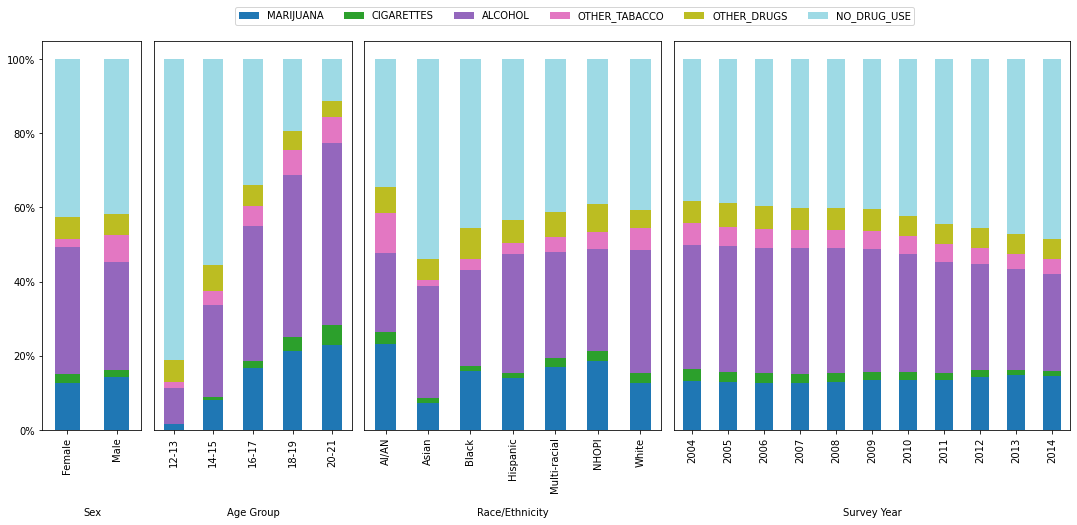

In [179]:
def plot_figure(df_):
    cols = ['MARIJUANA', 'CIGARETTES', 'ALCOHOL', 'OTHER_TABACCO', 'OTHER_DRUGS', 'NO_DRUG_USE']
    prop_sex = pd.crosstab(index=df_['SEX'], columns=df_['CLASS'], normalize="index") * 100
    prop_race = pd.crosstab(index=df_['RACE'], columns=df_['CLASS'], normalize="index") * 100
    prop_age = pd.crosstab(index=df_['AGE_GROUP'], columns=df_['CLASS'], normalize="index") * 100
    prop_year = pd.crosstab(index=df_['YEAR'], columns=df_['CLASS'], normalize="index") * 100
    figure, axis = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 2, 3, 4]})
    figure.set_size_inches(15, 6, forward=True)
    figure.tight_layout() 
    prop_sex[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[0], legend=None, xlabel='Sex')
    prop_age[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[1], legend=None, xlabel='Age Group')
    prop_race[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[2], legend=None, xlabel='Race/Ethnicity')
    prop_year[cols].plot(kind='bar', stacked=True, colormap='tab20', ax=axis[3], legend=None, xlabel='Survey Year')
    axis[0].yaxis.set_major_formatter('{x:1.0f}%')
    axis[1].set_yticks([])
    axis[2].set_yticks([])
    axis[3].set_yticks([])
    axis[0].xaxis.set_label_coords(.5, -.2)
    axis[1].xaxis.set_label_coords(.5, -.2)
    axis[2].xaxis.set_label_coords(.5, -.2)
    axis[3].xaxis.set_label_coords(.5, -.2)
    plt.subplots_adjust(wspace=0.05)
    plt.legend(loc='upper center', bbox_to_anchor=(-0.25, 1.1),  ncol = 6)
    # plt.savefig('figure_1.png', facecolor='white', transparent=False, bbox_inches='tight', pad_inches=.5)
    plt.show()
    
plot_figure(df)
# plot_figure(get_unencoded_df(df, df_enc))

# Plot Table 1

In [393]:
from scipy.stats.contingency import relative_risk
from scipy.stats import norm
from zepid import RiskRatio
from statsmodels.discrete.discrete_model import MNLogit
import statsmodels.api as st

In [395]:
df_slice = df.copy() # df[df.CLASS.isin(['MARIJUANA', 'NO_DRUG_USE'])]
df_slice['CLASS'] = df_slice.CLASS.astype('category')
df_slice['AGE'] = df_slice.AGE.astype(np.int32)
df_slice['YEAR'] = df_slice.YEAR.astype(np.int32)
X = pd.get_dummies(df_slice[['YEAR', 'RACE', 'AGE', 'SEX']])
y = df_slice[['CLASS']]
X.shape, y.shape

((296467, 11), (296467, 1))

In [396]:
X.head()

,YEAR,AGE,RACE_AI/AN,RACE_Asian,RACE_Black,RACE_Hispanic,RACE_Multi-racial,RACE_NHOPI,RACE_White,SEX_Female,SEX_Male
0,2010,20,0,0,1,0,0,0,0,0,1
1,2010,15,0,0,0,1,0,0,0,1,0
2,2010,18,0,0,0,0,0,0,1,1,0
3,2010,13,0,0,0,1,0,0,0,0,1
4,2010,20,0,0,0,1,0,0,0,0,1


In [397]:
y.head()

,CLASS
0,MARIJUANA
1,MARIJUANA
2,ALCOHOL
3,NO_DRUG_USE
4,OTHER_TABACCO


In [495]:
X_c = st.add_constant(X, prepend = True)
model = sm.MNLogit(y, X_c)
result = model.fit(method='newton', maxiter=100, full_output=True)

Optimization terminated successfully.
         Current function value: 1.213960
         Iterations 8


In [496]:
print(result.summary())

                          MNLogit Regression Results                          
Dep. Variable:                  CLASS   No. Observations:               296467
Model:                        MNLogit   Df Residuals:                   296412
Method:                           MLE   Df Model:                           50
Date:                Tue, 19 Jul 2022   Pseudo R-squ.:                  0.1278
Time:                        15:57:48   Log-Likelihood:            -3.5990e+05
converged:                       True   LL-Null:                   -4.1263e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
   CLASS=CIGARETTES       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  64.8319        nan        nan        nan         nan         nan
YEAR                   -0.0562      0.004    -13.177      0.000      -0.065      -0.048
AGE             

In [497]:
print(result.summary2())

                                Results: MNLogit
Model:                    MNLogit              Pseudo R-squared:     0.128      
Dependent Variable:       CLASS                AIC:                  719907.8895
Date:                     2022-07-19 15:58     BIC:                  720490.8725
No. Observations:         296467               Log-Likelihood:       -3.5990e+05
Df Model:                 50                   LL-Null:              -4.1263e+05
Df Residuals:             296412               LLR p-value:          0.0000     
Converged:                1.0000               Scale:                1.0000     
No. Iterations:           8.0000                                                
--------------------------------------------------------------------------------
     CLASS = 0       Coef.    Std.Err.     t     P>|t|     [0.025       0.975]  
--------------------------------------------------------------------------------
            const   64.8319         nan      nan    nan     

In [498]:
result.pvalues

,0,1,2,3,4
const,NaN,9.998139e-01,NaN,0.999960,NaN
YEAR,1.184645e-39,5.722161e-74,0.000000,0.000641,0.941179
AGE,2.029024e-278,2.312612e-180,0.000000,0.000000,0.006113
RACE_AI/AN,NaN,NaN,0.999914,0.999993,NaN
RACE_Asian,NaN,NaN,0.999841,0.999995,NaN
RACE_Black,NaN,NaN,NaN,NaN,NaN
RACE_Hispanic,NaN,9.999402e-01,0.999941,0.999990,NaN
RACE_Multi-racial,NaN,9.999627e-01,0.999938,NaN,NaN
RACE_NHOPI,NaN,NaN,NaN,NaN,NaN
RACE_White,NaN,NaN,0.999877,NaN,NaN


## sklearn logistic regression

In [433]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2

In [407]:
model = LogisticRegression(random_state=42, multi_class='multinomial')
model.fit(X, y)

LogisticRegression(multi_class='multinomial', random_state=42)

In [434]:
scores, pvalues = chi2(X, y)

In [438]:
len(pvalues)

11

In [416]:
coefficients = pd.DataFrame(np.exp(model.coef_), index=model.classes_, columns=X.columns)
coefficients

,YEAR,AGE,RACE_AI/AN,RACE_Asian,RACE_Black,RACE_Hispanic,RACE_Multi-racial,RACE_NHOPI,RACE_White,SEX_Female,SEX_Male
ALCOHOL,0.999914,1.086917,0.988932,0.994902,0.949645,1.009498,0.995980,0.998325,1.066537,1.071277,0.933707
CIGARETTES,0.997210,1.271435,1.001110,0.997677,0.990181,0.988037,1.000755,1.000144,1.022526,1.011563,0.988624
MARIJUANA,0.998793,1.179815,1.010959,0.983506,1.022929,1.008125,1.012488,1.001496,0.961742,0.971857,1.028883
NO_DRUG_USE,1.003770,0.684860,0.991070,1.032548,1.033152,1.008635,0.989167,0.999607,0.948085,1.029771,0.970774
OTHER_DRUGS,1.001549,0.804863,1.001315,1.000047,1.026224,1.006846,1.003124,1.000600,0.962954,1.007636,0.992462
OTHER_TABACCO,0.998777,1.112684,1.006799,0.992024,0.980555,0.979287,0.998636,0.999831,1.044331,0.915079,1.092850


In [425]:
calc_df = coefficients[['SEX_Female', 'SEX_Male']][2:4]
calc_df

,SEX_Female,SEX_Male
MARIJUANA,0.971857,1.028883
NO_DRUG_USE,1.029771,0.970774


In [431]:
calc_df.iloc[0]/calc_df.iloc[1]

SEX_Female    0.943760
SEX_Male      1.059858
dtype: float64

In [432]:
1.059858/0.943760

1.1230164448588624

### pvalues

In [487]:
# src: https://pythonguides.com/scikit-learn-logistic-regression/

def logit_pvalue(model, X):
    p1 = model.predict_proba(X)
    n1 = len(p1)
    m1 = len(model.coef_[0]) + 1
    coefs = np.concatenate((model.coef_[0], np.array([model.intercept_[0]])))
    x_full = np.matrix(np.insert(np.array(X), 0, 1, axis = 1))
    answ = np.zeros((m1, m1))
    for i in range(n1):
        answ = answ + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p1[i,1] * p1[i, 0]
    vcov = np.linalg.inv(np.matrix(answ))
    se = np.sqrt(np.diag(vcov))
    t1 =  coefs/se  
    p1 = (1 - norm.cdf(abs(t1))) * 2
    return p1

print(logit_pvalue(model, X))

[1.         0.         0.2595267  0.99999997 0.99999973 0.99999995
 0.99999998 0.99999999 0.99999966 0.99999963 0.99999945 1.        ]


## risk ration (legacy)

In [66]:
rr = RiskRatio(reference=0)
rr.fit(df_temp, exposure='SEX', outcome='CLASS')

# Calculating P-values
est = rr.results['RiskRatio'][1:]
std = rr.results['SD(RR)'][1:]
z_score = np.log(est)/std
p_value = norm.sf(abs(z_score))*2
# Displaying results
print("RR: ", list(est))
print("P-value:", p_value)

RR:  [1.10703802596475]
P-value: [2.71128224e-31]


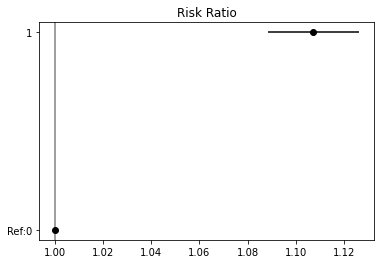

In [67]:
rr.plot()
plt.show()

In [18]:
rr.results

,Risk,SD(Risk),Risk_LCL,Risk_UCL,RiskRatio,SD(RR),RR_LCL,RR_UCL,CLR
Ref:0,0.229384,0.001472,0.226498,0.232269,1.000000,NaN,NaN,NaN,NaN
1,0.253936,0.001506,0.250984,0.256888,1.107038,0.008739,1.088237,1.126163,1.034851


# Plot Table 2

Table columns
- Heavy Marijuana Use Among Users (n=71,699)
- Cannabis Use Disorder Among Users (n=71,699)
- Alcohol Use Disorder Among Drinkers (n=136,399)
- Nicotine Dependence Among Smokers (n=89,202)
- Other Drug Use *c,d* (n=142,630)
    * *c* Other drugs included non-medical use of cocaine, hallucinogens, heroin, inhalants, analgesics, sedatives, stimulants, and tranquillizers.
    * *d* Those having used only one drug or all five types of drugs dropped from analyses (n=67,148) after controlling for number of drugs used due to no variance in the outcome.

Methodology
- **Heavy marijuana use** was defined as reporting marijuana use on either ≥20 or more days in the past month, or ≥300 days in the past year. **MRJMDAYS**, **MRJYDAYS**
- Participants were classified as having a **cannabis use disorder (CUD)** or **alcohol use disorder (AUD)** if, within the last 12 months, they had met one or more features of abuse or 3 or more features of dependence based on criteria in the Diagnostic and Statistical Manual of Mental Disorders, 4th Edition (American Psychiatric Association, 1994).  -> **DEPNDALC**, **DEPNDMRJ**
- Those whose total score on the Nicotine Dependence Syndrome Scale was ≥2.75 were classified as **having nicotine dependence (ND)** (Shiffman, Waters, & Hickcox, 2004). -> **NDSSDNSP**
- Any lifetime use of other drugs was based on responses to items about having ever used inhalants, cocaine, heroin, and non-medical prescription drugs

In [150]:
df.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,MRJMDAYS,MRJYDAYS,DEPNDALC,DEPNDMRJ,NDSSDNSP
0,2010,MARIJUANA,Male,Black,20-21,5,6,0,0,0
1,2010,MARIJUANA,Female,Hispanic,14-15,5,1,1,0,0
2,2010,ALCOHOL,Female,White,18-19,5,6,0,0,0
3,2010,NO_DRUG_USE,Male,Hispanic,12-13,5,6,0,0,0
4,2010,OTHER_TABACCO,Male,Hispanic,20-21,3,4,1,0,0


In [152]:
df[(df.CLASS!='NO_DRUG_USE')].shape

(171315, 10)

In [135]:
df.shape

(55268, 30)

# MST

In [22]:
import sys
sys.path.append("/home/stacy/GitHub/private-pgm/")
# sys.path.insert(1, "/home/stacy/GitHub/private-pgm/src")
from host_mst_wrapper.mst.mst import MSTSynthesizer
from host_mst_wrapper.mst.pmse import pmse_ratio

In [24]:
df_enc.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP
0,6,2,1,2,4
1,6,2,0,3,1
2,6,0,0,6,3
3,6,3,1,3,0
4,6,5,1,3,4


In [25]:
%%time
avg_pmse = 0
seeds = range(20)
for s in seeds:
    avg_pmse += pmse_ratio(df_enc, df_enc, seed=s)
print('Average pMSE:',round(avg_pmse/len(seeds),3))

Average pMSE: 1.065
CPU times: user 26.1 s, sys: 38.8 s, total: 1min 4s
Wall time: 8.89 s


In [26]:
df_domain = {
    "YEAR": 11,
    "CLASS": 6,
    "SEX": 2,
    "RACE": 7,
    "AGE_GROUP": 5,
}

domain_file_name = 'nsduh_processed_domain.json'
domain_file_path = os.path.join('../../data', domain_file_name)
with open(domain_file_path, 'w') as domain_file:
    json.dump(df_domain, domain_file)

In [27]:
%%time
cliques_to_try = [
    [],
    [('SEX', 'AGE_GROUP'), ('AGE_GROUP', 'RACE')],
    [('SEX', 'CLASS'), ('AGE_GROUP', 'CLASS'), ('RACE', 'CLASS')]
]

for cl in cliques_to_try:
    synth = MSTSynthesizer(epsilon=1.0, 
                        domain_path=domain_file_path,
                        custom_cliques=True,
                        cliques_set=cl)
    synth.fit(df_enc)
    mst_fake_data = synth.sample(samples=len(df_enc))
    avg_pmse = 0
    for s in seeds:
        avg_pmse += pmse_ratio(df_enc, mst_fake_data, seed=s)
    print('Average pMSE:',round(avg_pmse/len(seeds),3))
    print('')

Domain(YEAR: 11, CLASS: 6, SEX: 2, RACE: 7, AGE_GROUP: 5)
Index(['YEAR', 'CLASS', 'SEX', 'RACE', 'AGE_GROUP'], dtype='object')
[]
Average pMSE: 1.043

Domain(YEAR: 11, CLASS: 6, SEX: 2, RACE: 7, AGE_GROUP: 5)
Index(['YEAR', 'CLASS', 'SEX', 'RACE', 'AGE_GROUP'], dtype='object')
[('SEX', 'AGE_GROUP'), ('AGE_GROUP', 'RACE')]
Average pMSE: 0.993

Domain(YEAR: 11, CLASS: 6, SEX: 2, RACE: 7, AGE_GROUP: 5)
Index(['YEAR', 'CLASS', 'SEX', 'RACE', 'AGE_GROUP'], dtype='object')
[('SEX', 'CLASS'), ('AGE_GROUP', 'CLASS'), ('RACE', 'CLASS')]
Average pMSE: 1.218

CPU times: user 2min 28s, sys: 2min 31s, total: 5min
Wall time: 1min 31s


In [28]:
%%time
synth = MSTSynthesizer(epsilon=1.0, 
                        domain_path=domain_file_path)
synth.fit(df_enc)
mst_fake_data = synth.sample(samples=len(df_enc))

Domain(YEAR: 11, CLASS: 6, SEX: 2, RACE: 7, AGE_GROUP: 5)
Index(['YEAR', 'CLASS', 'SEX', 'RACE', 'AGE_GROUP'], dtype='object')
[('YEAR', 'CLASS'), ('CLASS', 'AGE_GROUP'), ('CLASS', 'RACE'), ('CLASS', 'SEX')]
CPU times: user 24.6 s, sys: 25.1 ms, total: 24.6 s
Wall time: 24.6 s


In [29]:
mst_fake_data.dtypes

YEAR         int64
CLASS        int64
SEX          int64
RACE         int64
AGE_GROUP    int64
dtype: object

In [30]:
df_fake = get_unencoded_df(df, mst_fake_data)
df_fake['SEX'] = df_fake['SEX'].astype('category')
df_fake['RACE'] = df_fake['RACE'].astype('category')
df_fake['AGE_GROUP'] = df_fake['AGE_GROUP'].astype('category')
df_fake['CLASS'] = df_fake['CLASS'].astype('category')
df_fake['YEAR'] = df_fake['YEAR'].astype('category')
df_fake.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP
0,2011,ALCOHOL,Female,White,14-15
1,2012,MARIJUANA,Male,White,16-17
2,2014,NO_DRUG_USE,Male,Hispanic,18-19
3,2013,ALCOHOL,Male,White,14-15
4,2012,NO_DRUG_USE,Male,AI/AN,12-13


In [31]:
df_fake.dtypes

YEAR         category
CLASS        category
SEX          category
RACE         category
AGE_GROUP    category
dtype: object

# Compare true and synthetic data

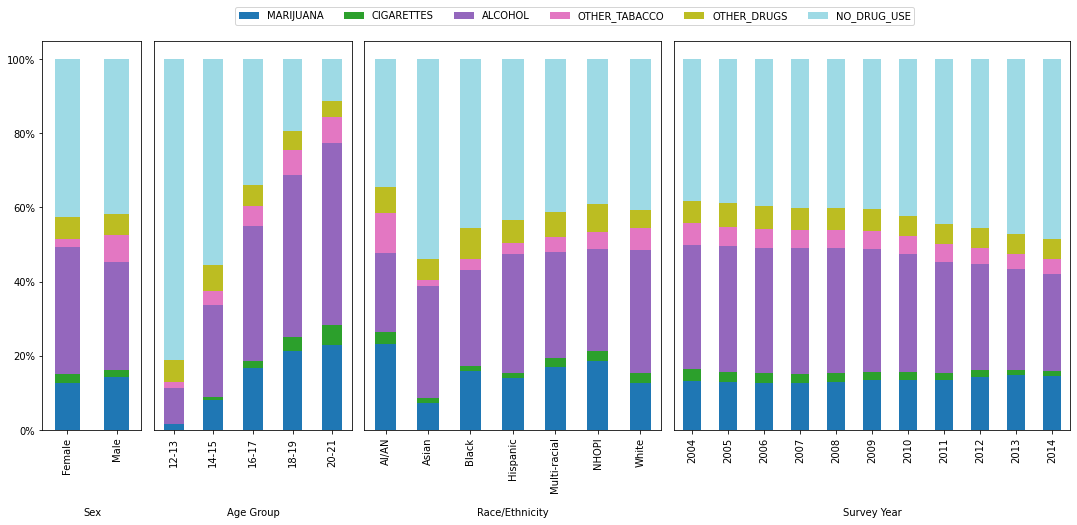

In [32]:
plot_figure(df)

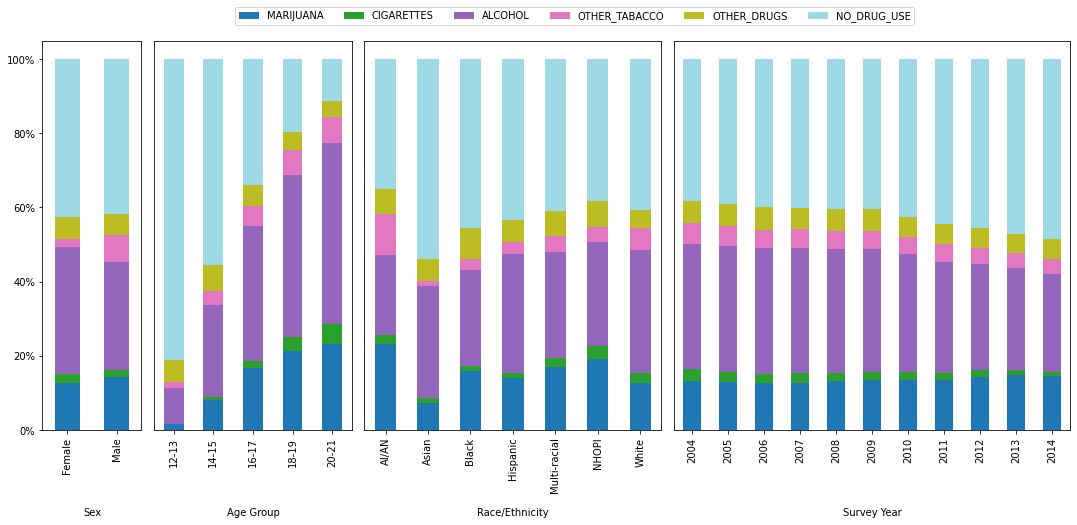

In [33]:
plot_figure(df_fake)

In [34]:
df.describe()

,YEAR,CLASS,SEX,RACE,AGE_GROUP
count,296467,296467,296467,296467,296467
unique,11,6,2,7,5
top,2011,NO_DRUG_USE,Male,White,16-17
freq,29121,125152,148945,175218,66936


In [35]:
df_fake.describe()

,YEAR,CLASS,SEX,RACE,AGE_GROUP
count,296467,296467,296467,296467,296467
unique,11,6,2,7,5
top,2011,NO_DRUG_USE,Male,White,16-17
freq,29127,125164,148971,175235,66956


In [36]:
def compare(df, df_fake, column_name):
    return pd.DataFrame([
            df[column_name].value_counts(),
            df_fake[column_name].value_counts(),
            df[column_name].value_counts() - df_fake[column_name].value_counts()
    ], index=['real', 'mst', 'diff'])

In [37]:
class_compare = compare(df, df_fake, 'CLASS')
class_compare

,NO_DRUG_USE,ALCOHOL,MARIJUANA,OTHER_DRUGS,OTHER_TABACCO,CIGARETTES
real,125152,93652,39914,16875,14320,6554
mst,125164,93669,39946,16848,14301,6539
diff,-12,-17,-32,27,19,15


In [38]:
class_compare.sum(axis=1)

real    296467
mst     296467
diff         0
dtype: int64

In [39]:
rr = RiskRatio(reference=1)
rr.fit(df, exposure='A', outcome='Y')

# Calculating P-values
est = rr.results['RiskRatio'][1:]
std = rr.results['SD(RR)'][1:]
z_score = np.log(est)/std
p_value = norm.sf(abs(z_score))*2

# Displaying results
print("RR:     ", list(est))
print("P-value:", p_value)

KeyError: 'A'

In [ ]:
rr = calculate_relative_risk(df_fake, ['MARIJUANA', 'NO_DRUG_USE'], 'SEX')
rr.relative_risk

In [ ]:
rr = calculate_relative_risk(df, ['MARIJUANA', 'NO_DRUG_USE'], 'SEX')
rr.relative_risk

-------------------------------